# Explotatry Data Analysis

Exploratory data analysis (EDA) is a crucial step in building a machine learning model. It provides a deep understanding of the problem and the characteristics of the dataset, guiding the choice of the most appropriate machine learning approach.

Through EDA, we can identify and address issues such as missing values, noisy data, and correlated features, ensuring a cleaner and more reliable dataset for modeling.

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from fia.plots import EdaPlotter

eda_plotter = EdaPlotter()

## Load The File

In [2]:
FILENAME = "./data/Base.csv"

df = pd.read_csv(FILENAME)
df.shape

(1000000, 32)

## Quick overview od the dataframe structure

We observe that there are a ton of features. We definitely do not need all of them. Why? Because some are more important, while others may even introduce more noise into the training of the model.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

## Looking For missing values in the Features

According the descripting of the feature in the kaggle page, the rows that contains a "-1" value represent a missing value. So let's have a look first what is the propotion for each feature. If there is too much missing, we will shoule remove theses features. If not we should replace -1 by nan. As models like xgboost can handle missing data.

As we see in the nex plot, we should remove the features bank_months_count, prev_address_months_count

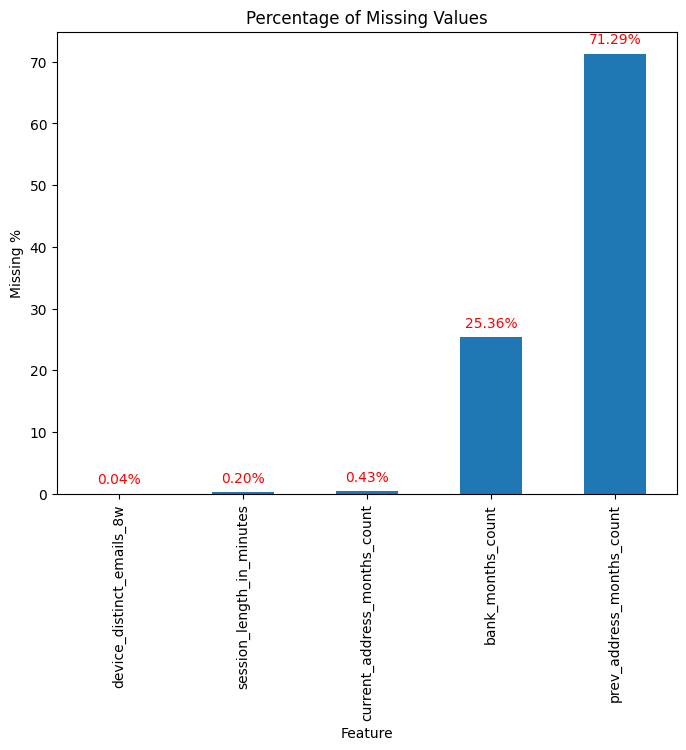

In [4]:
cols_missing = [
    'prev_address_months_count',
    'current_address_months_count',
    'bank_months_count',
    'session_length_in_minutes',
    'device_distinct_emails_8w',
    'intended_balcon_amount'
]

eda_plotter.plot_missing_values_proportion(df, cols_missing)

## Proportion of the Labels

We observe that we are dealing with a very unbalanced dataset, which was to be expected given that this is a fraud detection problem. Therefore, it will be necessary to use weights.

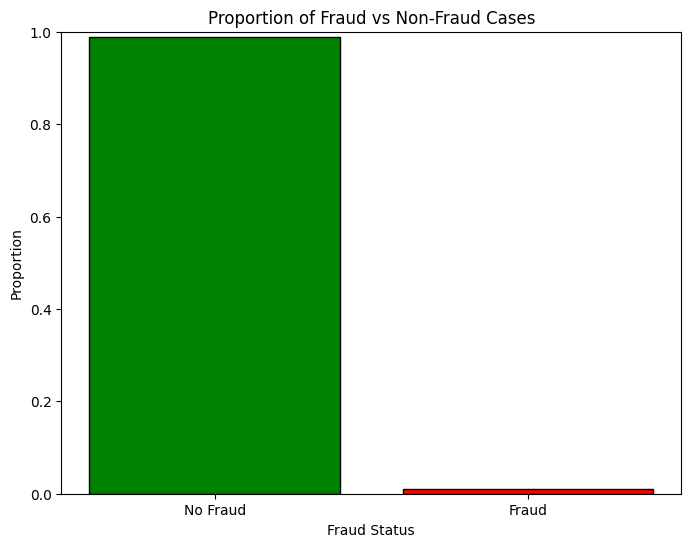

In [5]:
# Get the value counts
fraud_counts = df["fraud_bool"].value_counts(normalize=True)

# Mapping 0 to "No Fraud" and 1 to "Fraud"
fraud_labels = {0: "No Fraud", 1: "Fraud"}
fraud_counts.index = fraud_counts.index.map(fraud_labels)

# Plotting the proportions with custom labels
plt.figure(figsize=(8, 6))
plt.bar(fraud_counts.index, fraud_counts.values, color=['green', 'red'], edgecolor='black')
plt.title("Proportion of Fraud vs Non-Fraud Cases")
plt.xlabel("Fraud Status")
plt.ylabel("Proportion")
plt.ylim(0, 1)  # Keep the y-axis range from 0 to 1
plt.show()

## Plot the numerical features - Distribution

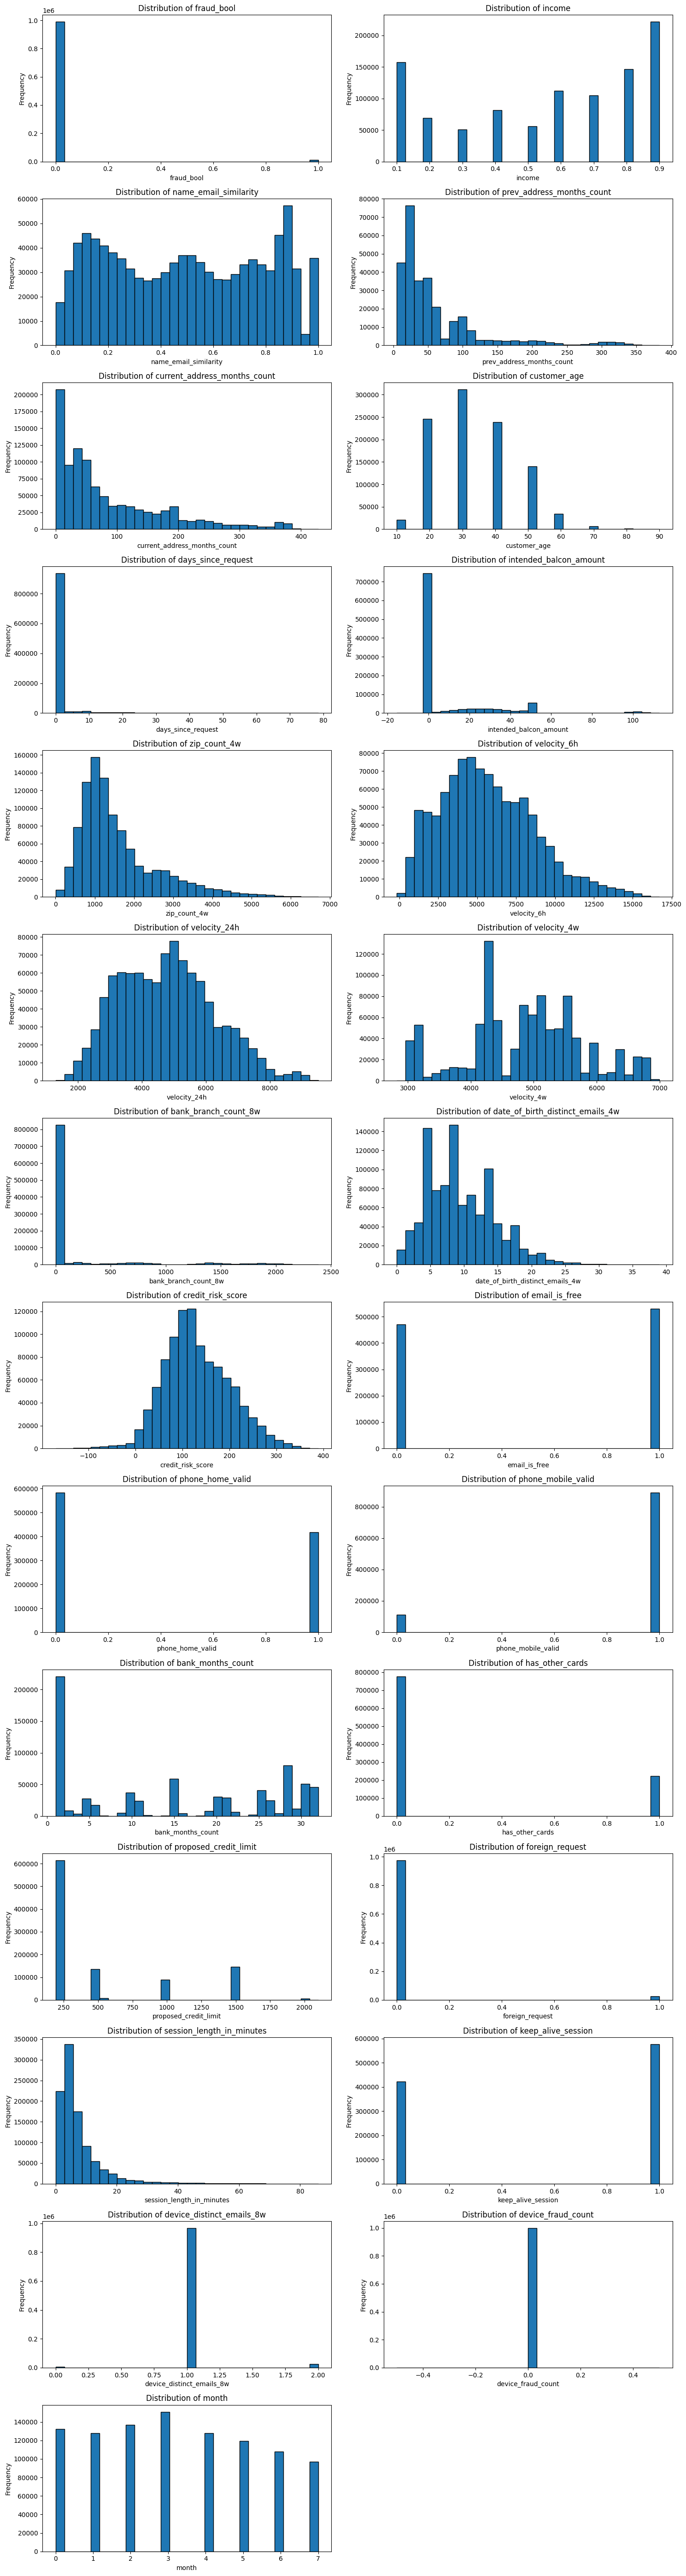

In [6]:
eda_plotter.plot_numerical_features(df)

## Plot the categorical features - Distribution

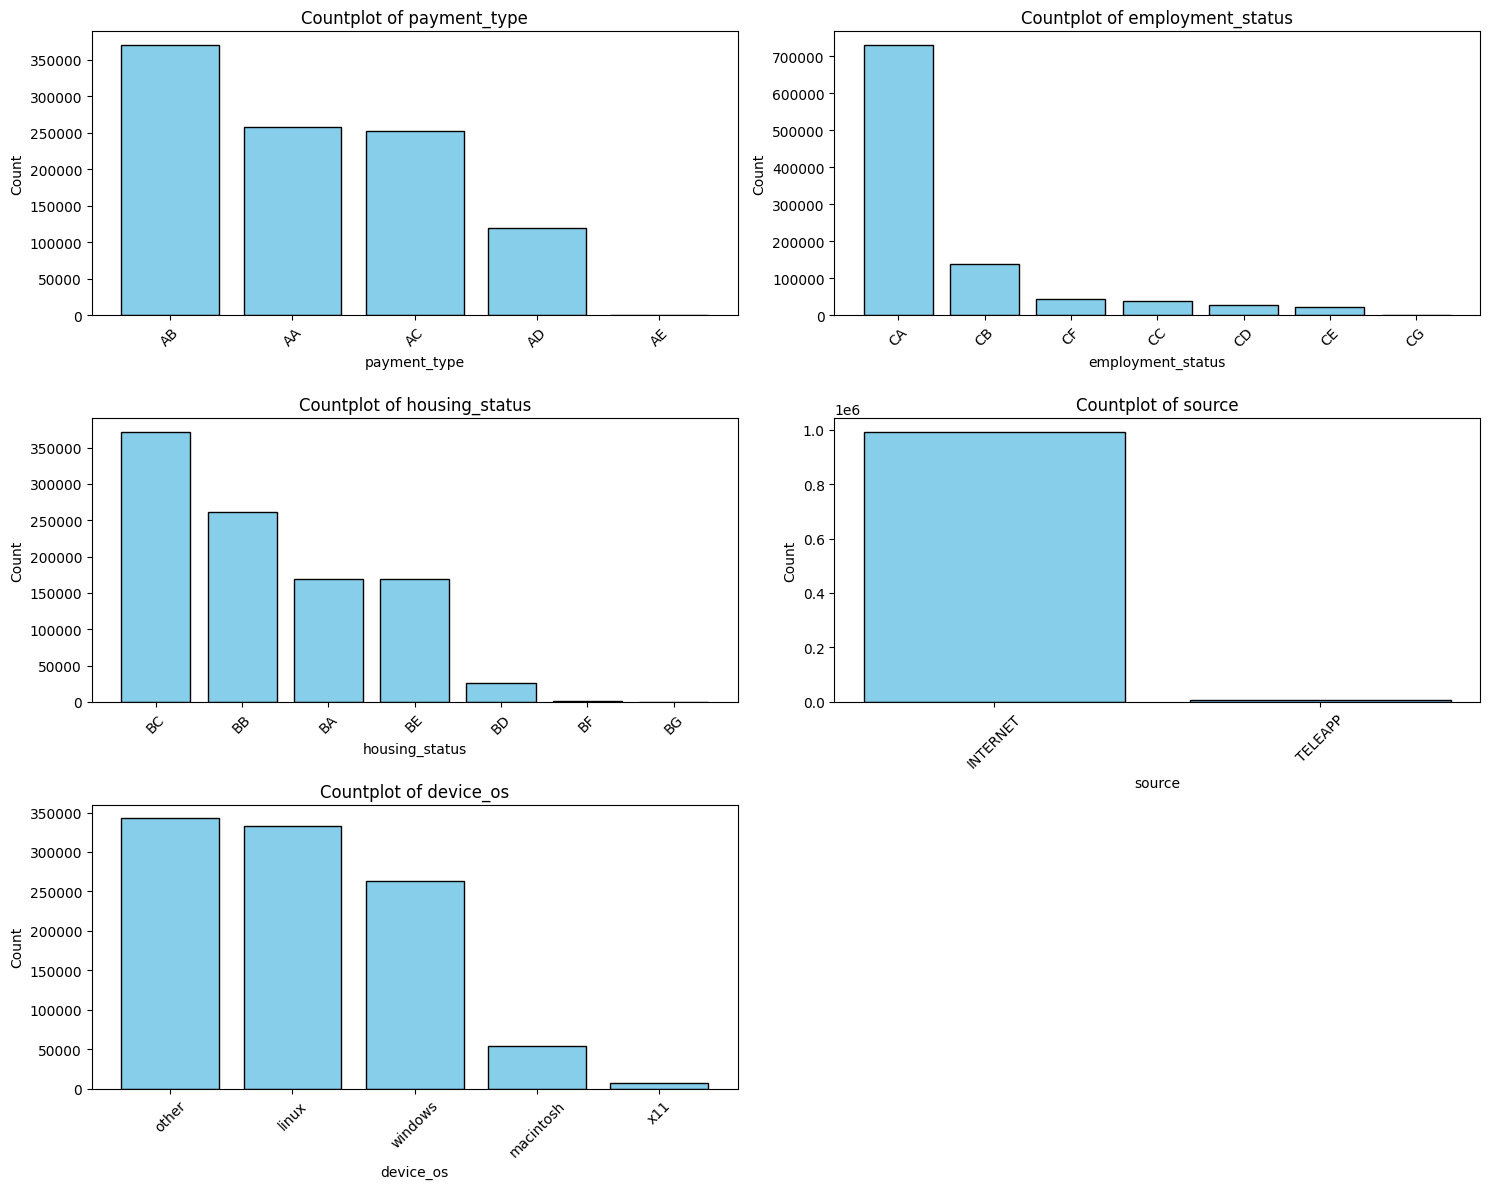

In [7]:
eda_plotter.plot_categorical_features(df)

## Features Correlation

High correlation between features can cause multicollinearity, which can make it difficult for machine learning models to learn effectively. By identifying and removing these features, the model can be simpler and potentially more robust.

We will remove the column "velocity_4w"

In [8]:
def identify_highly_correlated_features(dataframe : pd.DataFrame, threshold=0.80):

    # Select the numerical features
    numerical_features = dataframe.select_dtypes(include=['int64', 'float64']).columns
    X_numerical = dataframe[numerical_features]

    # Calculate the correlation matrix for numerical features
    corr_matrix = X_numerical.corr()

    # Identify pairs of highly correlated features
    high_corr_var = np.where(np.abs(corr_matrix) > threshold)
    high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) 
                     for x, y in zip(*high_corr_var) if x != y and x < y]

    # Return the list of highly correlated feature pairs
    return corr_matrix, high_corr_var

corr_matrix, high_corr_features = identify_highly_correlated_features(df, threshold=0.80)
print(high_corr_features)

[('velocity_4w', 'month')]


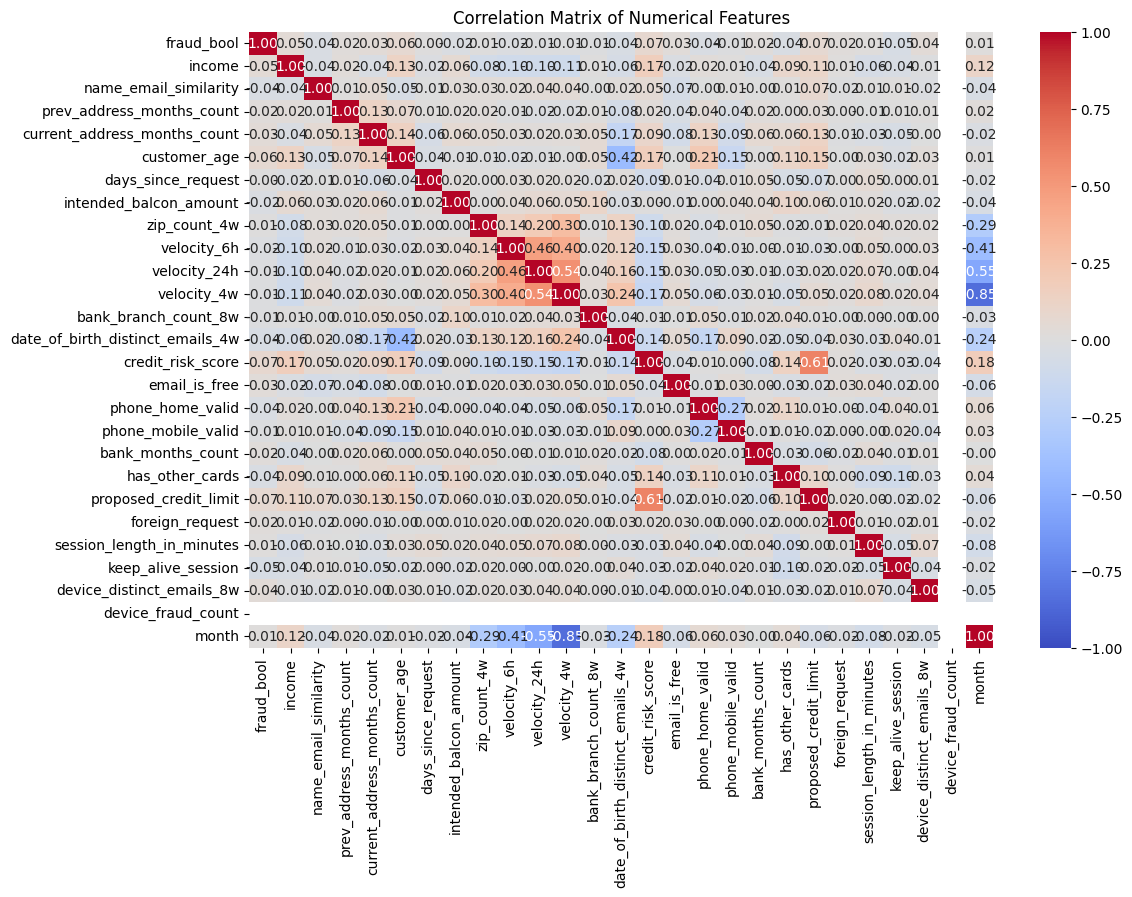

In [9]:
# Visualization of the correlation matrix (for numerical features only)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Skewness

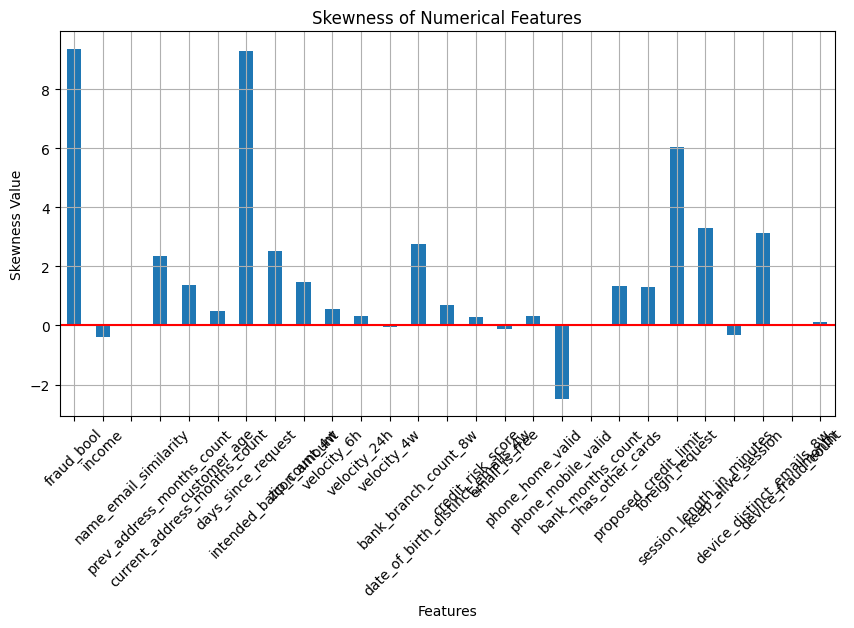

fraud_bool                          9.363838
income                             -0.386337
name_email_similarity               0.042839
prev_address_months_count           2.352988
current_address_months_count        1.384253
customer_age                        0.478079
days_since_request                  9.278955
intended_balcon_amount              2.507173
zip_count_4w                        1.456657
velocity_6h                         0.562682
velocity_24h                        0.331134
velocity_4w                        -0.060125
bank_branch_count_8w                2.747161
date_of_birth_distinct_emails_4w    0.703250
credit_risk_score                   0.295895
email_is_free                      -0.119758
phone_home_valid                    0.336350
phone_mobile_valid                 -2.487616
bank_months_count                   0.039016
has_other_cards                     1.330989
proposed_credit_limit               1.301410
foreign_request                     6.053306
session_le

In [10]:
eda_plotter.plot_skewness(df)

In this plot, the significant skewness in features can impact model performance in an unbalanced dataset. To mitigate this:

- Transform Skewed Features: Apply transformations like logarithmic or square root to reduce skewness, aiding better data interpretation.
- Adjust Model Strategy: Opt for models adept at handling imbalance, adjusting parameters for minority class emphasis.
- Focus on Metrics: Use precision, recall, and F1-score over accuracy to ensure fair evaluation.

# Conclusion

We have a highly unbalanced problem, which is quite common in fraud detection. We observed that while there are many features, not all of them are useful. We decided to remove those with excessive missing values and those that are highly correlated.

In fraud detection, the accuracy metric is not the most important. For example, if I told you we achieved 99% accuracy, it might simply mean that we accurately identified the non-fraudulent cases, which are usually the majority. What truly matters are the recall and precision for the fraud cases.

Given time constraints, I wasn't able to dive deeper into other aspects of data analysis. Ideally, I should have inspected the data for outliers and inliers, possibly using techniques like Isolation Forest or Local Outlier Factor. Additionally, since we're dealing with an unbalanced problem, I will address this issue using class weights, but exploring techniques like SMOTE would have been another valuable approach.

In [ ]:
# from sklearn.feature_selection import mutual_info_classif
# from sklearn.feature_selection import SelectKBest

# # 3. Feature selection using Mutual Information
# mi = mutual_info_classif(X_numerical, y)
# mi_series = pd.Series(mi, index=X_numerical.columns)
# mi_series = mi_series.sort_values(ascending=False)

# # Optionally, select the top K features (e.g., 10) for the model
# selected_features = mi_series.head(10).index

# # Final dataset with selected features
# X_selected = X_numerical[selected_features]

# # Plot Mutual Information feature importance
# plt.figure(figsize=(10, 6))
# mi_series.plot(kind='barh')
# plt.title('Mutual Information of Features')
# plt.xlabel('Mutual Information Score')
# plt.ylabel('Features')
# plt.gca().invert_yaxis()
# plt.show()